In [ ]:
#| default_exp io

# Image I/O

> Load, save, and normalize images

In this notebook, we define several functions for image and metadata loading and saving, as well as image normalization, and show how to use them with the data from the ``basics_example`` folder.

In [ ]:
#| export

import numpy as np
from scipy import ndimage
from skimage import transform
from skimage.io import imread, imsave
import h5py
from typing import Iterable
import tifffile
import json
import os
from copy import deepcopy
import warnings
import functools

import igl

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
#| export

def deprecated(func):
    """This is a decorator which can be used to mark functions
    as deprecated. It will result in a warning being emitted
    when the function is used."""
    @functools.wraps(func)
    def new_func(*args, **kwargs):
        warnings.simplefilter('always', DeprecationWarning)  # turn off filter
        warnings.warn("Call to deprecated function {}.".format(func.__name__),
                      category=DeprecationWarning,
                      stacklevel=2)
        warnings.simplefilter('default', DeprecationWarning)  # reset filter
        return func(*args, **kwargs)
    return new_func

### Load and subsample data for segmentation

Let's load an example dataset. We then enter the relevant metadata - the filename, resolution in microns, and how much we want to subsample for segmentation purposes.

In [ ]:
#| export

def adjust_axis_order(image, channel_axis=None):
    """
    Adjust axis order of image (numpy array) so that the channel axis is axis 0. 
    
    If the channel axis is not specified, it is inferred as the axis with the smallest number of entries.
    this function adds a singleton dimension if the image contains a single channel.
    Axis order is otherwise left unchanged. Image must have 3 axes (single channel volumetric)
    or four axes (multichannel volumetric). 
    
    Parameters
    ----------
    image: np.ndarray with 3 or 4 axes
        Input image.
    channel_axis: int or None, optional
        Channel axis
    
    Returns
    -------
    transposed image: np.ndarray with 4 axes
        Input image, channel now axis 0.
    """
    assert 2 < len(image.shape) <5, "image must have 3 or 4 axes"
    if len(image.shape) == 3:
        return image[np.newaxis]
    if channel_axis is None:
        channel_axis = np.argmin(image.shape)
    return np.moveaxis(image, channel_axis, 0)

In [ ]:
metadata_dict = {'filename': 'basics_example/basics_example',
                 'resolution_in_microns': (1, 0.36, 0.36), # you can typically get this from the .tif metadata
                 'subsampling_factors': (1, 1/3, 1/3),
                 'normal_offsets':np.linspace(-2, 2, 5) # normal offsets for map projection, in microns
                }

In [ ]:
image = adjust_axis_order(imread(f"{metadata_dict['filename']}.tif"))
print("image shape:", image.shape) # image shape - spatial axes are in z-x-y order

image shape: (2, 26, 454, 511)


In [ ]:
#| export

def subsample_image(image, subsampling_factors, use_block_averaging_if_possible=True):
    """
    Subsample (downscale) image by given factors.
    
    Reduce image size by given factors along each dimension. The subsampling_factors
    need to be _smaller than 1_. If the image is large,  subsampling can be performed
    by block averaging, which is much faster. In this case, you need to use inverse
    integer rescaling factors (e.g. 1/2, 1/3). If the number of pixels is not divisible
    by those factors, the subsampled image is padded by 0.
    
    Important: the chanel axis must be axis 0 (automatically done by adjust_axis_order)! 
    
    Parameters
    ----------
    image: np.ndarray
        Multichannel input image. Channel axis must be axis 0. (automatically done by adjust_axis_order).
    subsampling_factors : list or tuple of float or int
        Subsampling factors along each axis. A factor of 1/2 will reduce image size by 2x along that axis.
    use_block_averaging_if_possible : bool, default True
        Use fast block averaging if subsampling_factors are inverses of integers.

    Returns
    -------
    subsampled_image: np.ndarray
        Subsampled imaged
    """
    inverse_factors_are_integer = all([np.round(1/x, decimals=5) == int(1/x) for x in subsampling_factors])
    if inverse_factors_are_integer and use_block_averaging_if_possible:
        inverse_factors = tuple([int(1/x) for x in subsampling_factors])
        return np.stack([transform.downscale_local_mean(chn, inverse_factors) for chn in image], axis=0)
    return np.stack([transform.rescale(chn, subsampling_factors, preserve_range=True) for chn in image], axis=0)

In [ ]:
subsampled_image = subsample_image(image, metadata_dict['subsampling_factors'],
                                  use_block_averaging_if_possible=False)
print("subsampled image shape:", subsampled_image.shape)

subsampled image shape: (2, 26, 151, 170)


## Create 3d segmentation

Now create a 3d segmentation, in this case using ilastik. ilastik works best with input saved as `.h5` data sets. 

In [ ]:
#| export

def normalize_quantiles(image, quantiles=(0.01, 0.99), channel_axis=None):
    """
    Normalize a multi-dimensional image by setting given quantiles to 0 and 1.
    
    Parameters
    ----------
    image : np.array
        Multi-dimensional image.
    quantiles : tuple
        Image quantile to set to 0 and 1.
    channel_axis : int or None
        If None, the image is assumed to have only a single channel.
        If int, indicates the position of the channel axis. 
        Each channel is normalized separately.
    
    Returns
    -------
    image_normalized : np.array
        Normalized image, the same shape as input
    """
    if channel_axis is None:
        image_normalized = image - np.nanquantile(image, quantiles[0])
        image_normalized /= np.nanquantile(image_normalized, quantiles[1])
        image_normalized = np.nan_to_num(image_normalized)
        return image_normalized
    else:
        image_normalized = np.moveaxis(image, channel_axis, 0)
        image_normalized = np.stack([ch - np.nanquantile(ch, quantiles[0]) for ch in image_normalized])
        image_normalized = np.stack([ch / np.nanquantile(ch, quantiles[1]) for ch in image_normalized])
        image_normalized = np.moveaxis(np.nan_to_num(image_normalized), 0, channel_axis)
        return image_normalized

def normalize_mean_std(image, channel_axis=None):
    """
    Normalize a multi-dimensional image by setting mean to 0 and std dev to 1.
    
    Parameters
    ----------
    image : np.array
        Multi-dimensional image. The first axis needs to be the channel axis.
    channel_axis : int or None
        If None, the image is assumed to have only a single channel.
        If int, indicates the position of the channel axis. 
        Each channel is normalized separately.

    Returns
    -------
    image_normalized : np.array
        Normalized image, the same shape as input
    """
    if channel_axis is None:
        image_normalized = image - np.nanmean(image)
        image_normalized /= np.nanstd(image_normalized)
        return image_normalized
    else:
        image_normalized = np.moveaxis(image, channel_axis, 0)
        image_normalized = np.stack([ch - np.nanmean(ch) for ch in image_normalized])
        image_normalized = np.stack([ch / np.nanstd(ch) for ch in image_normalized])
        image_normalized = np.moveaxis(np.nan_to_num(image_normalized), 0, channel_axis)
        return image_normalized

In [ ]:
#| export

def write_h5(filename, image, h5_dataset_name="image", axis_order="CZYX"):
    """
    Write image (numpy array) as .h5 file (e.g. as input for ilastik).
    
    Parameters
    ----------
    filename : str
    image : np.array
        Multi-dimensional array
    h5_dataset_name : str
    axis_order : str
        "Meaning" of each array axis. 'C'=channel, 'X','Y','Z'= spatial axis,
        'T'=time. This is important if you want to use the .h5 as input for
        an ilastik model.
    
    Returns
    -------
    None
    """
    with h5py.File(filename, "w") as f:
        dataset = f.create_dataset('image', data=image)
        dataset.attrs['axes'] = axis_order

    return None

def read_h5(filename):
    """Read .h5 file (e.g. ilastik output) into numpy array. Loads alphabetically first entry in .h5."""
    with h5py.File(filename, "r") as f:
        arr = f[sorted(f.keys())[0]][()] 
    return arr

In [ ]:
# We now save the subsampled image as a .h5 file for input into ilastik for segmentation

write_h5(f"{metadata_dict['filename']}_subsampled.h5", subsampled_image)

In [ ]:
# After creating an ilastik project, training the model, and exporting the probabilities, we load the segmentation

segmentation = read_h5(f"{metadata_dict['filename']}_subsampled-image_Probabilities.h5")
segmentation = segmentation[0] # Select the first channel of the segmentation - it's the probability that a pixel
                               # is part of the sample
print("segmentation shape:", segmentation.shape)

segmentation shape: (26, 151, 170)


<matplotlib.image.AxesImage>

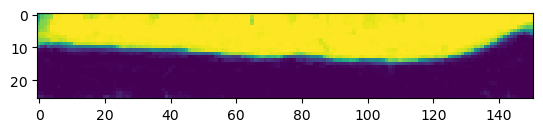

In [ ]:
# look at the segmentation in a cross-section

plt.imshow(segmentation[:,:,50], vmin=0, vmax=1)

### Saving results

We want to save the cartographic projections we will create both as `.tif` stack for quantitative analysis and as `.png`'s for visualization as mesh texture in blender. We will also save the metadata to a `.json` file

Annoyingly, we have to normalize our data and convert it to 8-bit to save it as png.

In [ ]:
#| export

def save_dict_to_json(filename, dictionary):
    """
    Save dictionary to .json file.
    
    Will automatically convert numpy arrays to lists for saving. If you get an error like "XXX is not JSON
    serializable", you need to ensure all your dictionary items are things that can be saved to text by json
    (strings, numbers, lists).
    
    Parameters
    ----------
    filename : str
        Filename to save to
    dictionary : dict
        Dictionary to save
    
    Returns
    -------
    None
    """
    serializable_dictionary = {key: val.tolist() if isinstance(val, np.ndarray) else val
                               for key, val in dictionary.items()}
    with open(filename, "w") as f:
        json.dump(serializable_dictionary, f)
    return None

In [ ]:
# save metadata
save_dict_to_json(f"{metadata_dict['filename']}_metadata.json", metadata_dict)

In [ ]:
#| export

def save_for_imageJ(filename, image, z_axis=None, channel_axis=None):
    """
    Save image as 32bit ImageJ compatible .tif file
    
    If channel_axis is not provided, it is inferred as the shortest axis.
    If z_axis is provided for a 4d array, it will be set as the default z-axis for ImageJ.
    """
    channel_axis = np.argmin(image.shape) if channel_axis is None else channel_axis
    if len(image.shape) == 3:
        transposed_image = np.moveaxis(image, channel_axis, 0)
        tifffile.imwrite(filename, transposed_image.astype(np.float32),
                         metadata={'axes': 'CYX'}, imagej=True,)
    elif len(image.shape) == 4:
        if z_axis is not None:
            transposed_image = np.moveaxis(image, (z_axis, channel_axis), (0,1))
        else:
            transposed_image = np.moveaxis(image, channel_axis, 1)
        tifffile.imwrite(filename, transposed_image.astype(np.float32),
                         metadata={'axes': 'ZCYX'}, imagej=True,)
    return None
    
def normalize_quantiles_for_png(image, quantiles=(0.01, 0.99)):
    """
    Normalize an image by setting given quantiles to 0 and 255 and converting to 8-bit, for saving as .png
    
    Also replaces nan by 0.
    
    Parameters
    ----------
    image : np.array
        Image (should be single-channel)
    quantiles : tuple
        Image quantile to set to 0 and 255.
    
    Returns
    -------
    image_normalized : np.array
        Normalized image, datatype np.uint8
    """
    image_normalized = image - np.nanquantile(image, quantiles[0])
    image_normalized /= np.nanquantile(image_normalized, quantiles[1])
    image_normalized = np.nan_to_num(np.round(np.clip(255*image_normalized, 0, 255)), nan=0)
    return image_normalized.astype(np.uint8)
    
    
def save_stack_for_blender(image, directory, normalization=(0.01, 0.99)):
    """
    Save multichannel volumetric image as a series of grayscale .png images. Can normalize data if desired.
    
    This function necessarily converts the image to 8 bit. Use a suitable normalization to ensure nothing 
    is lost.
    
    Parameters
    ----------
    image : 4d np.array
        Axis 0 is assumed to be the channel axis, axis 1 is the slicing axes, i.e. images will correspond to
        slices along axis 1.
    directory : str
        Path to save data to. Will create a directory if it doesn't exist
    normalization : tuple of float, or callable
        Whether to normalize the image before saving it. If None, no normalization is performed. If a
        tuple is given, it will be interpreted as quantiles to set to 0 and 255, respectively (over the
        whole channel, not each slice). If a callable is provided, it will be applied to each channel.
        
    Returns
    -------
    None
    
    """
    directory = directory.removesuffix('/')
    if not os.path.exists(directory):
        os.makedirs(directory)
    for ic, ch in enumerate(image):
        if callable(normalization):
            ch_normalized = normalization(ch)
        if isinstance(normalization, tuple):
            ch_normalized = normalize_quantiles_for_png(ch, quantiles=normalization)
        for islc, slc in enumerate(ch_normalized):
            slc = np.stack(3*[slc], axis=-1).astype(np.uint8) # necessary for saving as png
            imsave(f'{directory}/channel_{ic}_slice_{str(islc).zfill(3)}.png', slc, check_contrast=False)
    return None

In [ ]:
# read some data so we can check the saving function
projected_data = adjust_axis_order(imread(f"{metadata_dict['filename']}_projected.tif"))
print("Image shape", projected_data.shape)

Image shape (2, 5, 256, 256)


In [ ]:
save_for_imageJ(f"{metadata_dict['filename']}_projected.tif", projected_data, z_axis=1)

In [ ]:
texture_path = f"{os.getcwd()}/{metadata_dict['filename']}_textures"
save_stack_for_blender(projected_data, texture_path, normalization=(0.01, 0.99))